###Gradio測試
這是只有叫 Gemini 生成 Gradio 介面，模型還沒使用

https://huggingface.co/spaces/sunsmarterjieleaf/yolov12

In [ ]:
# --- 1. 安裝必要套件 (Colab 需要先執行這行) ---
!pip install gradio ultralytics opencv-python-headless -q

import gradio as gr
import cv2
import numpy as np
from ultralytics import YOLO
import os

# --- 2. 初始化設定 ---
# [cite_start]你的提案中是使用 YOLOv12m [cite: 9, 11]
# 在 Colab 中，如果你沒有上傳權重檔，我們會先用 yolov8n 讓程式能跑起來
MODEL_NAME = 'yolov12m.pt'

print(f"正在準備模型...")
if os.path.exists(MODEL_NAME):
    print(f"載入 {MODEL_NAME}...")
    model = YOLO(MODEL_NAME)
else:
    print(f"尚未上傳 {MODEL_NAME}，自動下載 yolov8n.pt 作為替代以供測試。")
    # Colab 下載速度快，直接下載標準模型
    model = YOLO('yolov8n.pt')

# 設定要偵測的車輛類別 (COCO dataset IDs)
# 2: car, 3: motorcycle, 5: bus, 7: truck
VEHICLE_CLASSES = [2, 3, 5, 7]

def analyze_risk(image):
    """
    核心邏輯：執行物件偵測並根據面積佔比計算風險等級
    [cite_start]依據提案方法論：面積佔比閾值法 (Area-based Thresholding) [cite: 13, 14]
    """
    if image is None:
        return None, "請上傳圖片"

    # 取得圖片總面積
    img_h, img_w = image.shape[:2]
    total_area = img_h * img_w

    # 執行 YOLO 偵測
    results = model(image)

    max_ratio = 0.0
    risk_level = "Safe"
    color_code = "#00FF00"
    status_text = "Safe: 車輛遠離"

    annotated_img = image.copy()

    # 遍歷偵測結果
    for result in results:
        boxes = result.boxes
        for box in boxes:
            cls_id = int(box.cls[0])

            if cls_id in VEHICLE_CLASSES:
                x1, y1, x2, y2 = map(int, box.xyxy[0])

                # 計算面積
                box_w = x2 - x1
                box_h = y2 - y1
                box_area = box_w * box_h

                # 計算佔比
                ratio = box_area / total_area

                if ratio > max_ratio:
                    max_ratio = ratio

                # 繪圖
                cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                label = f"{model.names[cls_id]} {ratio:.1%}"
                cv2.putText(annotated_img, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # [cite_start]判斷邏輯 [cite: 18, 19, 20]
    percentage = max_ratio * 100

    if max_ratio < 0.05:
        risk_level = "Safe"
        color_code = "#00FF00" # Green
        status_text = f"Safe (安全)<br>佔比: {percentage:.2f}% (< 5%)"
    elif 0.05 <= max_ratio <= 0.20:
        risk_level = "Warning"
        color_code = "#FFFF00" # Yellow
        status_text = f"Warning (接近中)<br>佔比: {percentage:.2f}% (5% - 20%)"
    else:
        risk_level = "Danger"
        color_code = "#FF0000" # Red
        status_text = f"DANGER (盲區危險)<br>佔比: {percentage:.2f}% (> 20%)"

    # HTML 顯示
    traffic_light_html = f"""
    <div style="text-align: center;">
        <div style="
            width: 120px;
            height: 120px;
            background-color: {color_code};
            border-radius: 50%;
            display: flex;
            align-items: center;
            justify-content: center;
            margin: 0 auto;
            border: 4px solid #333;
            box-shadow: 0 0 15px {color_code};
        ">
            <h2 style="color: black; margin: 0; font-family: Arial;">{risk_level}</h2>
        </div>
        <h3 style="margin-top: 15px;">{status_text}</h3>
    </div>
    """

    return annotated_img, traffic_light_html

# --- 3. 建立 Gradio 介面 ---
with gr.Blocks(title="VisionGuard Demo") as demo:
    gr.Markdown("# VisionGuard 專案展示")
    gr.Markdown("上傳圖片以測試盲點偵測與距離警示系統")

    with gr.Row():
        input_image = gr.Image(label="輸入影像", type="numpy")
        with gr.Column():
            light_output = gr.HTML(label="警示燈號")
            output_image = gr.Image(label="偵測結果")

    btn = gr.Button("執行偵測", variant="primary")
    btn.click(analyze_risk, inputs=input_image, outputs=[output_image, light_output])

# --- 關鍵修改：share=True ---
print("正在啟動 Gradio，請點擊下方的 public URL...")
demo.launch(share=True, debug=True)

正在準備模型...
尚未上傳 yolov12m.pt，自動下載 yolov8n.pt 作為替代以供測試。
正在啟動 Gradio，請點擊下方的 public URL...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9de08e5b2a646d5a63.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",


0: 448x640 1 truck, 174.8ms
Speed: 13.9ms preprocess, 174.8ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://9de08e5b2a646d5a63.gradio.live


###API 測試
這是測試呼叫API

In [ ]:
pip install gradio_client

In [ ]:
from gradio_client import Client

client = Client("sunsmarterjieleaf/yolov12")
result = client.predict(
		input_type="Image",
		api_name="/update_visibility"
)
print(result)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded as API: https://sunsmarterjieleaf-yolov12.hf.space ✔
({'visible': True, '__type__': 'update'}, {'visible': False, '__type__': 'update'}, {'visible': True, '__type__': 'update'}, {'visible': False, '__type__': 'update'})


In [ ]:
from gradio_client import Client

print("正在連接 API...")
client = Client("sunsmarterjieleaf/yolov12")

print("\n====== 關鍵資訊：請查看下方列出的 API ======")
client.view_api()
print("==========================================\n")

正在連接 API...
Loaded as API: https://sunsmarterjieleaf-yolov12.hf.space ✔

====== 關鍵資訊：請查看下方列出的 API ======
Client.predict() Usage Info
---------------------------
Named API endpoints: 2

 - predict(input_type, api_name="/update_visibility") -> (image, video, annotated_image, annotated_video)
    Parameters:
     - [Radio] input_type: Literal['Image', 'Video'] (not required, defaults to:   Image)  
    Returns:
     - [Image] image: filepath 
     - [Video] video: Dict(video: filepath, subtitles: filepath | None) 
     - [Image] annotated_image: filepath 
     - [Video] annotated_video: Dict(video: filepath, subtitles: filepath | None) 

 - predict(image, video, model_id, image_size, conf_threshold, input_type, api_name="/run_inference") -> (annotated_image, annotated_video)
    Parameters:
     - [Image] image: filepath (required)  
     - [Video] video: Dict(video: filepath, subtitles: filepath | None) (required)  
     - [Dropdown] model_id: Literal['yolov12n.pt', 'yolov12s.pt', 'yolov

In [ ]:
from gradio_client import Client, handle_file
try:
    # 1. 初始化
    client = Client("sunsmarterjieleaf/yolov12")

    # 2. 設定測試圖片 (這裡用公車圖當範例，你可以換成自己的圖片網址或路徑)
    img_url = "https://ultralytics.com/images/bus.jpg"

    print("正在傳送圖片進行辨識 (嘗試使用 /run_inference)...")

    # 3. 呼叫辨識 API
    # 注意：這裡的參數順序必須跟 Space 定義的一模一樣
    result = client.predict(
        image=handle_file(img_url), # 輸入圖片
        video=None,                 # 影片留空
        model_id="yolov12m.pt",     # 指定模型
        image_size=640,             # 圖片大小
        conf_threshold=0.25,        # 信心分數
        iou_threshold=0.45,         # IOU 閾值 (有些模型需要這個參數)
        max_det=1000,               # 最大偵測數
        input_type="Image",         # 模式
        api_name="/run_inference"   # <--- 關鍵在這裡，嘗試這個名稱
    )

    # 4. 顯示結果
    print(f"成功！結果圖片路徑: {result[0]}")

    # 在 Colab 顯示圖片
    import cv2
    from google.colab.patches import cv2_imshow
    img = cv2.imread(result[0])
    cv2_imshow(img)

except Exception as e:
    print("\n發生錯誤，可能是參數數量不對或 API 名稱錯誤。")
    print("錯誤訊息:", e)
    print("\n請將上方 'client.view_api()' 的輸出結果貼給我，我幫你修正參數！")

Loaded as API: https://sunsmarterjieleaf-yolov12.hf.space ✔
正在傳送圖片進行辨識 (嘗試使用 /run_inference)...

發生錯誤，可能是參數數量不對或 API 名稱錯誤。
錯誤訊息: Parameter `iou_threshold` is not a valid key-word argument. Please click on 'view API' in the footer of the Gradio app to see usage.

請將上方 'client.view_api()' 的輸出結果貼給我，我幫你修正參數！


正在連接 API...
Loaded as API: https://sunsmarterjieleaf-yolov12.hf.space ✔
正在傳送圖片進行 YOLOv12 辨識...
辨識成功！結果已下載至: /tmp/gradio/ba68e16b5f16973f869f3cf0c2fc736971ae711165f7e17ef03d3b3b21503aa6/image.webp


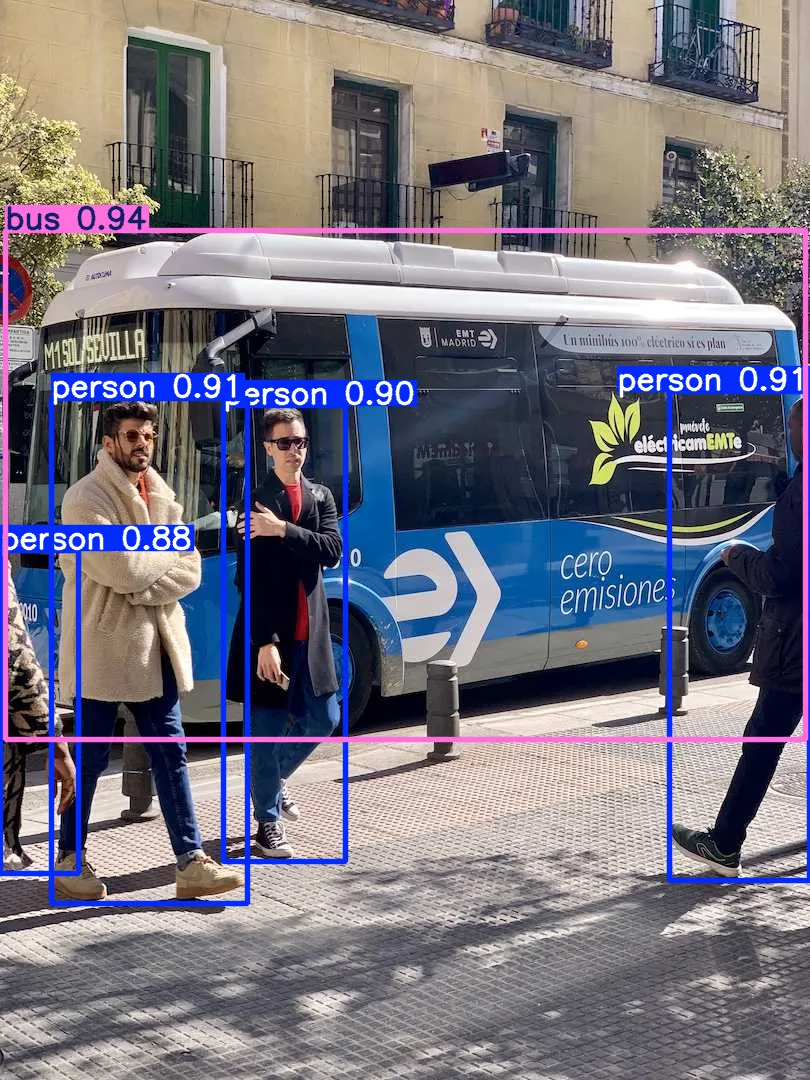

In [ ]:
from gradio_client import Client, handle_file
import cv2
from google.colab.patches import cv2_imshow

try:
    # 1. 初始化 Client
    print("正在連接 API...")
    client = Client("sunsmarterjieleaf/yolov12")

    # 2. 設定測試圖片 (你可以換成自己的圖片網址)
    # 這裡使用 YOLO 常用的測試圖
    img_url = "https://ultralytics.com/images/bus.jpg"

    print("正在傳送圖片進行 YOLOv12 辨識...")

    # 3. 呼叫辨識 API (已根據你的 view_api 結果移除錯誤參數)
    # 參數順序對應: image, video, model_id, image_size, conf_threshold, input_type
    result = client.predict(
        image=handle_file(img_url), # [Image] (必填)
        video=None,                 # [Video] (雖然必填但選 Image 模式時可傳 None)
        model_id="yolov12m.pt",     # [Dropdown] 模型選擇
        image_size=640,             # [Slider] 圖片大小
        conf_threshold=0.25,        # [Slider] 信心分數
        input_type="Image",         # [Radio] 模式選擇
        api_name="/run_inference"   # 正確的 API 端點名稱
    )

    # result 會回傳一個 tuple: (annotated_image_path, annotated_video_path)
    output_image_path = result[0]
    print(f"辨識成功！結果已下載至: {output_image_path}")

    # 4. 顯示結果圖片
    img = cv2.imread(output_image_path)
    cv2_imshow(img)

except Exception as e:
    print(f"發生錯誤: {e}")

###整合
把前面兩個合起來

####Test 1

In [ ]:
# 1. 安裝必要套件
!pip install gradio gradio_client opencv-python-headless -q

import gradio as gr
from gradio_client import Client, handle_file
import cv2
import numpy as np

# --- 核心演算法：從圖片中「反推」YOLO 框 ---
def extract_boxes_and_analyze(image_path):
    """
    這就是你要的「抓回來再另外算」的功能。
    利用 OpenCV 偵測圖片中的「綠色框」，反推車輛面積。
    """
    # 讀取 API 回傳的圖片
    img = cv2.imread(image_path)
    if img is None:
        return img, 0, "讀取錯誤"

    img_h, img_w = img.shape[:2]
    total_area = img_h * img_w

    # 1. 轉換到 HSV 色彩空間 (比較好抓顏色)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 2. 設定「綠色」的範圍 (YOLO 預設框通常是螢光綠)
    # 這裡的範圍可能需要微調，但通常 YOLO 的綠色很標準
    # H: 35-85 (綠色系), S: 100-255 (鮮豔), V: 100-255 (亮)
    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])

    # 3. 建立遮罩 (Mask)：只保留綠色部分
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # 4. 尋找輪廓 (Contours)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    max_ratio = 0.0

    # 為了視覺化，我們在原圖上再畫一次我們「抓到」的框 (用藍色區別)
    debug_img = img.copy()

    for cnt in contours:
        # 過濾太小的雜訊 (例如文字造成的綠色噪點)
        if cv2.contourArea(cnt) < 50:
            continue

        # 取得外接矩形 (x, y, w, h)
        x, y, w, h = cv2.boundingRect(cnt)

        # 計算面積 (Box Area)
        box_area = w * h

        # 計算佔比 (Ratio)
        ratio = box_area / total_area

        if ratio > max_ratio:
            max_ratio = ratio

        # 畫藍色框證明我們有抓到
        cv2.rectangle(debug_img, (x, y), (x+w, y+h), (255, 0, 0), 3)

    return debug_img, max_ratio

# --- Gradio 整合介面 ---
HF_SPACE = "sunsmarterjieleaf/yolov12"
client = Client(HF_SPACE)

def process_pipeline(input_img_path):
    if input_img_path is None:
        return None, None

    print("1. 呼叫遠端 API 辨識中...")
    try:
        # 呼叫 API 取得畫好框的圖
        result = client.predict(
            image=handle_file(input_img_path),
            video=None,
            model_id="yolov12m.pt",
            image_size=640,
            conf_threshold=0.25,
            input_type="Image",
            api_name="/run_inference"
        )
        annotated_path = result[0]

        print("2. 正在反推座標並計算危險度...")
        # 呼叫上面的 OpenCV 分析函式
        final_img, max_ratio = extract_boxes_and_analyze(annotated_path)

        # --- 依照你的提案邏輯判斷燈號  ---
        percentage = max_ratio * 100

        if max_ratio < 0.05:
            risk = "Safe"
            color = "#00FF00" # Green
            desc = "車輛遠離"
        elif 0.05 <= max_ratio <= 0.20:
            risk = "Warning"
            color = "#FFFF00" # Yellow
            desc = "接近中"
        else:
            risk = "Danger"
            color = "#FF0000" # Red
            desc = "位於盲區，禁止變換車道"

        # 產生 HTML 輸出
        html_output = f"""
        <div style="text-align: center;">
            <div style="
                width: 120px; height: 120px; background-color: {color};
                border-radius: 50%; margin: 0 auto; display: flex;
                align-items: center; justify-content: center;
                box-shadow: 0 0 20px {color}; border: 4px solid #333;">
                <h2 style="margin:0; color:black;">{risk}</h2>
            </div>
            <h3>{desc}</h3>
            <p>最大面積佔比: <b>{percentage:.2f}%</b></p>
        </div>
        """

        return final_img, html_output

    except Exception as e:
        print(f"Error: {e}")
        return None, f"發生錯誤: {e}"

# --- 啟動 Gradio ---
with gr.Blocks(title="VisionGuard (Hybrid Mode)") as demo:
    gr.Markdown("# VisionGuard (混合模式)")
    gr.Markdown("使用遠端 API 進行辨識 -> 本地 OpenCV 反推面積 -> 判斷紅綠燈")

    with gr.Row():
        inp = gr.Image(label="上傳圖片", type="filepath")
        with gr.Column():
            out_html = gr.HTML(label="危險評估")
            out_img = gr.Image(label="OpenCV 二次驗證圖 (藍框為反推結果)")

    btn = gr.Button("執行", variant="primary")
    btn.click(process_pipeline, inputs=inp, outputs=[out_img, out_html])

demo.launch(share=True, debug=True)

Loaded as API: https://sunsmarterjieleaf-yolov12.hf.space ✔
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://22a1f8564757b82fd9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

1. 呼叫遠端 API 辨識中...
2. 正在反推座標並計算危險度...


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

1. 呼叫遠端 API 辨識中...
2. 正在反推座標並計算危險度...


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

1. 呼叫遠端 API 辨識中...
2. 正在反推座標並計算危險度...
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://22a1f8564757b82fd9.gradio.live


####Test 2
期末demo用這個版本

In [ ]:
!pip install gradio gradio_client opencv-python-headless -q

import gradio as gr
from gradio_client import Client, handle_file
import cv2
import numpy as np
import shutil

# --- 1. 設定 API ---
HF_SPACE = "sunsmarterjieleaf/yolov12"
client = Client(HF_SPACE)

def get_box_area_ratio(original_img, result_img_path):
    """
    黑魔法函式：透過「影像相減」逆向推算框的面積佔比
    """
    # 讀取 API 回傳的結果圖
    result_img = cv2.imread(result_img_path)
    if result_img is None: return 0.0

    # 確保兩張圖尺寸一致 (API 可能會調整大小，需將原圖縮放以匹配結果圖)
    h, w, _ = result_img.shape
    original_resized = cv2.resize(original_img, (w, h))

    # 1. 計算差異 (絕對值差) -> 背景會變黑，只有框線和文字會亮起來
    diff = cv2.absdiff(original_resized, result_img)

    # 2. 轉灰階並二值化
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

    # 3. 尋找輪廓
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return 0.0

    # 4. 找出最大的輪廓 (假設最大的那個就是主要偵測到的車)
    # 我們不只算線條面積，而是算該輪廓的「外接矩形」面積
    max_area = 0
    total_img_area = w * h

    for cnt in contours:
        x, y, box_w, box_h = cv2.boundingRect(cnt)
        current_area = box_w * box_h

        # 過濾太小的雜訊 (例如小文字)
        if current_area > max_area:
            max_area = current_area

    return max_area / total_img_area

def api_inference_with_logic(image_path):
    if image_path is None:
        return None, "請上傳圖片"

    print("呼叫 API 中...")
    try:
        # 1. 呼叫 YOLOv12 API
        result = client.predict(
            image=handle_file(image_path),
            video=None,
            model_id="yolov12m.pt",
            image_size=640,
            conf_threshold=0.25,
            input_type="Image",
            api_name="/run_inference"
        )

        output_path = result[0]

        # 為了計算，我們需要讀取原始圖片 (Gradio 傳入的是路徑)
        original_img = cv2.imread(image_path)

        # 2. 【關鍵步驟】執行逆向面積計算
        ratio = get_box_area_ratio(original_img, output_path)
        percentage = ratio * 100

        # 3. 判斷紅綠燈邏輯 (依照你的提案書 [cite: 18, 19, 20])
        # Safe: < 5%, Warning: 5-20%, Danger: > 20%
        if ratio < 0.05:
            risk_level = "Safe"
            color_code = "#00FF00" # 綠
            status_text = f"Safe (安全)<br>面積佔比: {percentage:.2f}%"
        elif 0.05 <= ratio <= 0.20:
            risk_level = "Warning"
            color_code = "#FFFF00" # 黃
            status_text = f"Warning (注意)<br>面積佔比: {percentage:.2f}%"
        else:
            risk_level = "Danger"
            color_code = "#FF0000" # 紅
            status_text = f"DANGER (盲區危險)<br>面積佔比: {percentage:.2f}%"

        # 4. 生成 HTML 燈號
        traffic_light_html = f"""
        <div style="text-align: center;">
            <div style="
                width: 120px; height: 120px;
                background-color: {color_code};
                border-radius: 50%;
                margin: 0 auto;
                border: 4px solid #333;
                box-shadow: 0 0 15px {color_code};
                display: flex; align-items: center; justify-content: center;
            ">
                <h2 style="color: black; margin: 0;">{risk_level}</h2>
            </div>
            <h3 style="margin-top: 15px;">{status_text}</h3>
            <p style="color: gray; font-size: 0.8em;">(數據來源: 影像逆向推算)</p>
        </div>
        """

        return output_path, traffic_light_html

    except Exception as e:
        return None, f"錯誤: {str(e)}"

# --- 介面 ---
with gr.Blocks(title="VisionGuard Final") as demo:
    gr.Markdown("# VisionGuard ")

    with gr.Row():
        inp = gr.Image(label="原始圖片", type="filepath")
        out_img = gr.Image(label="API 辨識結果")
        out_html = gr.HTML(label="安全判定")

    btn = gr.Button("執行偵測與測距", variant="primary")
    btn.click(api_inference_with_logic, inputs=inp, outputs=[out_img, out_html])

demo.launch(share=True, debug=True)

Loaded as API: https://sunsmarterjieleaf-yolov12.hf.space ✔
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://38fa6d7c76f2da62b8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

呼叫 API 中...


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

呼叫 API 中...


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

呼叫 API 中...


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

呼叫 API 中...
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://38fa6d7c76f2da62b8.gradio.live
